# EventBasedPortfolioManager - A portfolio manager for strategies.




## 1 EventBasedBacktester - A interface for strategy class that takes in a dataframe, and then trades on the data.

1. Data Collection
2. Trade Execution
   1. Transaction costs
   2. Manages position and quantity tracking for multiple securities
   3. Handles basic buy/sell order execution
   4. Records trade details including timestamp, price, quantity
3. Risk Management
   1. Tracks realized account balance
   2. Monitors unrealized positions
   3. Set maximum position size
   4. Stops account if value falls below 0.
4. Performance Analysis
   1. Calculates various performance metrics (Sharpe ratio, drawdown, etc.)
   2. Provides visualization of performance through multiple plots
   3. Tracks trade history and portfolio evolution

In [10]:
import logging

from scipy import stats

logger = logging.getLogger(__name__)

from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from typing import Optional, Union, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf

class OrderType(Enum):
    MARKET = "MARKET"
    # LIMIT = "LIMIT"
    # STOP = "STOP"

# A trade is an order that has been executed. Assume that all trades were executed immediately. 
@dataclass
class Trade:
    timestamp : int
    datetime : datetime
    position: int
    type: OrderType
    quantity: float
    price: float
    transaction_cost: float

@dataclass
class StrategyPerformance:
    symbol: str
    timestamp : int
    datetime : datetime
    position : int
    quantity: float
    price: float
    transaction_cost: float
    intial_capital : float
    realized_balance: float
    unrealized_balance: float
    total_balance: float
@dataclass
class ReturnsPerformance:
    symbol: str
    timestamp : int
    datetime: datetime
    position: int
    price: float
    total_balance : float

    # Calculated in performance
    # capital_regular_returns: float
    # capital_log_returns: float
    # capital_returns_logcumsum: float

class EventBasedBacktester:
    """
    Event based backtest for generic trading strategy.
    """
    def __init__(self, symbol, start, end, interval, capital, transaction_fee, verbose = True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.data = self.prepare_data()
        """
        Trade settings
        """
        self.initial_capital = capital
        self.transaction_fee = transaction_fee

        """
        Performance values.
        """
        self.current_position = 0
        self.current_capital = capital
        self.transaction_costs = 0
        self.trades : List[Trade] = []
        self.strategy_performance : List[StrategyPerformance] = []
        self.returns_performance : List[ReturnsPerformance] = []
        """
        Miscellanous
        """
        self.minimum_balance = self.initial_capital * 0.1
        self.stop_trading = False
        self.verbose = verbose

    def prepare_data(self):
        """
        Ensure data is in correct format with proper column names
        """
        stock_data = yf.Ticker(self.symbol)
        data = stock_data.history(start=self.start, end=self.end, interval=self.interval).reset_index().rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume',
            'Date': 'datetime'
        })
        data['timestamp'] = data['datetime'].apply(lambda x: int(x.timestamp() * 1000))
        data = data.sort_values('timestamp', ascending=True).reset_index(drop=True)
        data['logreturns_close'] = np.log(data['close'] / data['close'].shift(1))
        data['returns_close'] = (data['close'] / data['close'].shift(1)) - 1
        return data
    """
    Strategy Function - to override strategy() method.
    """
    def strategy(self, row):
        # Should use the execute_order() method to execute trades.
        raise NotImplementedError("Implement the strategy method")
    
    def run_strategy(self):
        for i, r in self.data.iterrows():
            self.strategy(row = r)
            # Closes strategy on the last timestamp
            if i == len(self.data) - 1 and self.current_position != 0:
                self.close_current_position(timestamp=self.data.iloc[-1]['timestamp'])
            # Adds returns on the last trade, which will include transaction costs because of total balance.
            self.returns_performance.append(
                ReturnsPerformance(
                    symbol=self.symbol,
                    timestamp=r['timestamp'],
                    datetime=pd.to_datetime(r['timestamp'], unit='ms'),
                    position=self.current_position,
                    price=r['close'],
                    total_balance=self.total_balance(timestamp=r['timestamp'])
                )
            )
        # Close final position
        
    """
    Plotters
    """

    """
    Getters
    """
    def get_current_position(self):
        return self.current_position
    def get_timestamp_price(self, timestamp):
        return self.data[self.data['timestamp'] == timestamp].iloc[0]

    def realized_balance(self):
        return self.current_capital
    
    def unrealized_balance(self, timestamp):
        return self.current_position * self.get_timestamp_price(timestamp)['close']

    def total_balance(self, timestamp):
        return self.realized_balance() + self.unrealized_balance(timestamp)

    def get_most_recent_trade(self):
        return self.trades[-1]
    """
    Trade
    """
    def add_portfolio_performance(self, timestamp, position, quantity, price, transaction_cost, initial_capital):
        portfolio_performance = StrategyPerformance(
            symbol=self.symbol,
            timestamp=timestamp,
            datetime=pd.to_datetime(timestamp, unit='ms'),
            position=position,
            quantity=quantity,
            price=price,
            transaction_cost=transaction_cost,
            intial_capital=initial_capital,
            realized_balance=self.realized_balance(),
            unrealized_balance=self.unrealized_balance(timestamp),
            total_balance=self.total_balance(timestamp)
        )
        self.strategy_performance.append(portfolio_performance)
        if self.verbose == True:
            print(f"Timestamp : {timestamp} / Datetime {pd.to_datetime(timestamp, unit='ms').strftime("%d/%m/%Y, %H:%M:%S")}, Position : {"LONG" if position == 1 else "SHORT"}, Quantity : {quantity}, Current Price : {price}, Transaction Cost : {transaction_cost}, Initial Capital : {initial_capital}, Realized Balance : {self.realized_balance()}, Unrealized Balance : {self.unrealized_balance(timestamp=timestamp)}, Total Balance : {self.total_balance(timestamp=timestamp)}")
    
    def add_trade(self, timestamp, position, type, quantity, price, transaction_cost):
        trade = Trade(timestamp=timestamp, 
                    datetime=pd.to_datetime(timestamp, unit='ms'),
                    position=position, 
                    type=type, 
                    quantity=quantity, 
                    price=price, 
                    transaction_cost=transaction_cost)
        self.trades.append(trade)
        if self.verbose == True:
            print(f"Trade executed at timestamp : {timestamp}, Position : {"LONG" if position == 1 else "SHORT"}, Quantity : {quantity}, Price : {price}")
    
    def execute_order(self, timestamp, position: int, quantity : int = None, type : OrderType = OrderType.MARKET):
        if position not in [-1, 1]:
            raise ValueError("Position must be either 1 (long) or -1 (short)")
        initial_capital = self.total_balance(timestamp=timestamp)
        # We assume that trades can be excuted at close, even though this might be unrealistic. Alternatively we use Open-to-Open to calculate the results.
        current_price = self.get_timestamp_price(timestamp)['close']
        # Calculate positions depending on amount.
        transaction_cost = (current_price * quantity) * self.transaction_fee
        quantity_cost = current_price * quantity
        total_cost = quantity_cost + transaction_cost
        if position == 1:
            # if total_cost > self.current_capital:
            #     # raise ValueError("Insufficient capital for long position")
            #     print("Insufficient capital for long position")
            #     return
            self.current_capital = self.current_capital - total_cost
            self.current_position += quantity
            self.transaction_costs += transaction_cost
        elif position == -1:
            # # Check if resulting position would exceed minimum balance requirement
            # if (self.current_capital + (current_price * quantity) - transaction_cost) < self.minimum_balance:
            #     # raise ValueError("Short position would exceed minimum balance requirement")
            #     print("Short position would exceed minimum balance requirement")
            #     return 
            # Capital added for a short position - in this case we are borrowing, but you have to check in get_total_balance to ensure that the trade does not go past minimum balance.
            self.current_capital = self.current_capital + quantity_cost - transaction_cost
            self.current_position -= quantity
            self.transaction_costs += transaction_cost
        else:
            raise ValueError("Position must be either 1 or -1")
        self.add_trade(
            timestamp=timestamp,
            position=position,
            type=type,
            quantity=quantity,
            price=current_price, 
            transaction_cost=transaction_cost,
        )
        self.add_portfolio_performance(
            timestamp=timestamp,
            position=position,
            quantity=quantity,
            price=current_price,
            transaction_cost=transaction_cost,
            initial_capital = initial_capital,
            )
    def long_all(self, timestamp):
        """
        Enter a long position with all available capital.
        
        Args:
            timestamp: The timestamp of the order
        """
        if self.total_balance(timestamp=timestamp) <= 0:
            print("No capital available for long position")
            return
            
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.total_balance(timestamp=timestamp)  / (current_price * (1 + self.transaction_fee)))
        
        self.execute_order(
            timestamp=timestamp,
            position=1,
            quantity=max_quantity
        )

    def short_all(self, timestamp):
        """
        Enter a short position with all available capital.
        
        Args:
            timestamp: The timestamp of the order
        """
        if self.total_balance(timestamp=timestamp) <= self.minimum_balance:
            print("No capital available for short position")
            return
        
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.total_balance(timestamp=timestamp) / (current_price * (1 + self.transaction_fee)))
        
        if max_quantity <= 0:
            print("Available capital insufficient for minimum trade size")
            return
        
        self.execute_order(
            timestamp=timestamp,
            position=-1,
            quantity=max_quantity
        )
        
    def close_current_position(self, timestamp):
        """
        Close the current position completely at the current market price.
        
        Args:
            timestamp: The timestamp of the order
        """
        if self.current_position == 0:
            print("No position to close")
            return
            
        # If current_position is positive, we need to sell (short)
        # If current_position is negative, we need to buy (long)
        closing_position = -1 if self.current_position > 0 else 1
        
        self.execute_order(
            timestamp=timestamp,
            position=closing_position,
            quantity=self.current_position if self.current_position > 0 else -self.current_position
        )
    
    def check_balance(self, timestamp):
        """
        Check if the total balance is above the minimum requirement.
        If not, close all positions and stop trading.
        
        Args:
            timestamp: The timestamp to check the balance
        """
        total_balance = self.total_balance(timestamp=timestamp)
        
        if total_balance < self.minimum_balance:
            logger.warning(f"Balance ({total_balance}) below minimum requirement ({self.minimum_balance})")
            try:
                self.close_current_position(timestamp)
            except Exception as e:
                logger.error(f"Failed to close positions on minimum balance breach: {str(e)}")
            
            self.stop_trading = True
            print(f"Minimum balance reached. Stopping trading. Final balance: {total_balance}")
            print(f"Final position: {self.current_position}")
    def get_performance(self):
        """
        Calculate performance metrics based on balance returns and log returns
        """
        # Convert strategy performance to DataFrame
        df = pd.DataFrame(self.returns_performance)
        
        # Calculate returns
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['balance_logreturns'] = np.log(df['total_balance'] / df['total_balance'].shift(1))
        df['balance_logreturns_cumsum'] = df['balance_logreturns'].cumsum()
        
        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100
        
        # Time period calculations
        trading_days = len(df)
        annual_factor = 252  # Trading days in a year
        years = trading_days / annual_factor
        
        # 1. Total capital at end
        final_capital = df['total_balance'].iloc[-1]
        
        # 2. Annual regular returns
        total_return = (final_capital / self.initial_capital) - 1
        annual_return = ((1 + total_return) ** (1/years) - 1) * 100
        
        # 3. Annual regular std deviation
        daily_std = df['balance_returns'].std()
        annual_std = daily_std * np.sqrt(annual_factor) * 100
        
        # 4. Annual Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        excess_return = annual_return/100 - risk_free_rate
        sharpe_ratio = excess_return / (annual_std/100)
        
        # 5. Returns on investment for period
        total_return_pct = total_return * 100
        
        # 6. Maximum drawdown
        max_drawdown = abs(df['drawdown'].min())     

        # 7. Maximum drawdown period
        # Calculate drawdown periods
        drawdown_periods = []
        current_drawdown = 0
        in_drawdown = False
        
        for dd in df['drawdown']:
            if dd < 0:  # In drawdown
                if not in_drawdown:
                    in_drawdown = True
                current_drawdown += 1
            else:  # Not in drawdown
                if in_drawdown:
                    drawdown_periods.append(current_drawdown)
                    current_drawdown = 0
                    in_drawdown = False
        
        if current_drawdown > 0:  # If still in drawdown at the end
            drawdown_periods.append(current_drawdown)
        
        max_drawdown_period = max(drawdown_periods) if drawdown_periods else 0
        
        # 8. Sortino Ratio
        negative_returns = df['balance_returns'][df['balance_returns'] < 0]
        downside_std = np.sqrt(annual_factor) * np.sqrt(np.mean(negative_returns**2))
        sortino_ratio = (annual_return/100 - risk_free_rate) / downside_std if downside_std != 0 else 0
        
        # 9. Total trades
        total_trades = len(self.trades)
        
        return {
            'total_capital': final_capital,
            'total_return': total_return_pct,
            'annual_returns': annual_return,
            'annual_std': annual_std,
            'max_drawdown': max_drawdown,
            'max_drawdown_period': max_drawdown_period,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'daily_std': daily_std * 100,
            'avg_daily_return': df['balance_returns'].mean() * 100,
            'total_trades': total_trades,
        }
    def print_performance_summary(self, metrics=None):
        """
        Print formatted performance metrics with border styling
        """
        if metrics is None:
            metrics = self.get_performance()
        
        border = "=" * 50
        print(f"\n{border}")
        print("Performance Metrics")
        print(f"The total capital at end of strategy: ${metrics['total_capital']:,.2f}")
        print(f"The annual regular returns: {metrics['annual_returns']:.2f} %")
        print(f"The annual regular std deviation: {metrics['annual_std']:.2f} %")
        print(f"The annual Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"The returns on investment from {self.start} to {self.end} by this strategy is {metrics['total_return']:.2f} %")
        print(f"The maximum drawdown: {metrics['max_drawdown']:.2f} %")
        print(f"The maximum drawdown period: {metrics['max_drawdown_period']:.2f} days")
        print(f"The annual Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"The total trades taken by the strategy: {metrics['total_trades']}")
        print(f"{border}")
    def plot_strategy_performance(self):
        """
        Create comprehensive strategy performance visualization with 6 subplots
        """
        # Get performance metrics
        metrics = self.get_performance()
        
        # Convert strategy performance to DataFrame
        df = pd.DataFrame([vars(p) for p in self.returns_performance])
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['cum_returns'] = (1 + df['balance_returns']).cumprod()
        df['log_cum_returns'] = np.log(df['cum_returns'])
        
        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100
        
        # Create figure with subplots
        fig = plt.figure(figsize=(30, 20))
        gs = fig.add_gridspec(3, 2, hspace=0.3)
        
        # 1. Cumulative Log Returns (Top Left)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(df['datetime'], df['log_cum_returns'], color='blue', linewidth=1.5)
        ax1.set_title('Cumulative Log Returns')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Log Returns')
        ax1.grid(True)
        
        # 2. Returns Distribution (Top Right)
        ax2 = fig.add_subplot(gs[0, 1])
        sns.histplot(df['balance_returns'].dropna(), kde=True, ax=ax2, bins=50)
        ax2.axvline(df['balance_returns'].mean(), color='r', linestyle='--', 
                    label=f'Mean: {df["balance_returns"].mean():.4f}')
        ax2.set_title('Returns Distribution')
        ax2.set_xlabel('Returns')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        # 3. Maximum Drawdown (Middle Left)
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.fill_between(df['datetime'], df['drawdown'], 0, color='red', alpha=0.3)
        ax3.set_title('Drawdown')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Drawdown %')
        ax3.grid(True)
        
        # 4. Equity Curve (Middle Right)
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(df['datetime'], df['total_balance'], color='green', linewidth=1.5)
        ax4.axhline(y=self.initial_capital, color='r', linestyle='--', 
                    label=f'Initial Capital: ${self.initial_capital:,.0f}')
        ax4.set_title('Equity Curve')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Portfolio Value ($)')
        ax4.legend()
        ax4.grid(True)
        
        # 5. Rolling Metrics (Bottom Left)
        ax5 = fig.add_subplot(gs[2, 0])
        window = 20  # 20-day rolling window
        rolling_returns = df['balance_returns'].rolling(window=window).mean() * 252 * 100  # Annualized
        rolling_vol = df['balance_returns'].rolling(window=window).std() * np.sqrt(252) * 100  # Annualized
        # rolling_sharpe = rolling_returns / rolling_vol
        
        ax5.plot(df['datetime'], rolling_returns, label='Returns', color='blue')
        ax5.plot(df['datetime'], rolling_vol, label='Volatility', color='red')
        # ax5.plot(df['datetime'], rolling_sharpe, label='Sharpe', color='green')
        ax5.set_title(f'{window}-Day Rolling Metrics')
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Percentage (%)')
        ax5.legend()
        ax5.grid(True)
        
        # 6. Trade Analysis (Bottom Right)
        ax6 = fig.add_subplot(gs[2, 1])
        
        # Convert trades to DataFrame for analysis
        trades_df = pd.DataFrame([{
            'datetime': t.datetime,
            'position': t.position,
            'price': t.price,
            'quantity': t.quantity,
            'cost': t.transaction_cost
        } for t in self.trades])
        
        if not trades_df.empty:
            # Plot trade markers
            long_trades = trades_df[trades_df['position'] > 0]
            short_trades = trades_df[trades_df['position'] < 0]
            
            # Plot price line
            ax6.plot(df['datetime'], df['price'], color='gray', alpha=0.5, zorder=1)
            
            # Plot trade points
            ax6.scatter(long_trades['datetime'], long_trades['price'], 
                    marker='^', color='green', s=100, label='Long', zorder=2)
            ax6.scatter(short_trades['datetime'], short_trades['price'], 
                    marker='v', color='red', s=100, label='Short', zorder=2)
            
            # Add volume indication through marker size
            # for _, trade in trades_df.iterrows():
            #     size = np.sqrt(trade['quantity']) * 20  # Scale marker size based on quantity
            #     color = 'green' if trade['position'] > 0 else 'red'
            #     ax6.scatter(trade['datetime'], trade['price'], 
            #             s=size, color=color, alpha=0.3, zorder=1)
        
        ax6.set_title('Trade Analysis')
        ax6.set_xlabel('Date')
        ax6.set_ylabel('Price')
        ax6.legend()
        ax6.grid(True)
        
        # Add main title with key metrics
        title = (f'Strategy Performance Analysis - {self.symbol}\n'
                f'Return: {metrics["total_return"]:.1f}% | '
                f'Sharpe: {metrics["sharpe_ratio"]:.2f} | '
                f'Max DD: {metrics["max_drawdown"]:.1f}% | '
                f'Trades: {metrics["total_trades"]}')
        fig.suptitle(title, fontsize=12, y=0.95)
        
        plt.tight_layout()
        plt.show()

In [ ]:
from ta.trend import SMAIndicator

class MAStrategy(EventBasedBacktester):
    def __init__(self, symbol, start, end, interval, capital, transaction_fee, verbose=True, short_window=40, long_window=100):
        if short_window >= long_window:
            raise ValueError("Short window must be smaller than long window")
        
        super().__init__(symbol, start, end, interval, capital, transaction_fee, verbose)
        self.short_window = short_window
        self.long_window = long_window

        """
        Run Moving Average Crossover strategy
        """
        # Calculate indicators
        self.data['SMA'] = SMAIndicator(
            close=self.data["close"], 
            window=self.short_window, 
            fillna=True  # Changed to True to handle initial NaN values
        ).sma_indicator()
        
        self.data['LMA'] = SMAIndicator(
            close=self.data["close"], 
            window=self.long_window, 
            fillna=True  # Changed to True to handle initial NaN values
        ).sma_indicator()

    def strategy(self, row):
        sma_value = row['SMA']
        lma_value = row['LMA']

        # Entry logic with crossover detection
        if sma_value > lma_value:
            # Long signal
            if self.current_position <= 0:  # Currently short or no position
                if self.current_position < 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.long_all(timestamp=row['timestamp'])
        elif sma_value < lma_value:
            # Short signal
            if self.current_position >= 0:  # Currently long or no position
                if self.current_position > 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.short_all(timestamp=row['timestamp'])  


MAStrategy_1 = MAStrategy(
    symbol="AAPL",
    start="2010-01-01",
    end="2012-01-01",
    interval="1d",
    capital=100000,
    transaction_fee=0.001,
    verbose=True,
)
MAStrategy_1.run_strategy()

In [ ]:
results = MAStrategy_1.get_performance()
results

In [ ]:
MAStrategy_1.print_performance_summary()

In [ ]:
MAStrategy_1.plot_strategy_performance()
plt.show()

# RSISTRATEGY

In [ ]:
def rank_by_market_cap(tickers):
    """
    Rank tickers by market cap from lowest to highest
    
    Parameters:
    tickers (list): List of stock tickers
    
    Returns:
    DataFrame with tickers ranked by market cap
    """
    data = []
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            market_cap = stock.info.get('marketCap', 0)
            company_name = stock.info.get('longName', ticker)
            
            data.append({
                'ticker': ticker,
                'company_name': company_name,
                'market_cap': market_cap,
                'market_cap_B': market_cap / 1e9  # Convert to billions
            })
            
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create DataFrame and sort
    df = pd.DataFrame(data)
    df = df.sort_values('market_cap')  # Sort from lowest to highest
    df['rank'] = range(1, len(df) + 1)  # Add ranking column
    
    # Format market cap numbers
    df['market_cap_str'] = df['market_cap_B'].apply(lambda x: f"${x:.2f}B")
    
    return df[['rank', 'ticker', 'company_name', 'market_cap_str', 'market_cap_B']]

qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL', 'ABNB',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# Get rankings
rankings = rank_by_market_cap(qqq_components).reset_index(drop=True)
rankings['marketcapweight'] = 
rankings


,rank,ticker,company_name,market_cap_str,market_cap_B
0,1,DXCM,"DexCom, Inc.",$27.22B,27.224502
1,2,KHC,The Kraft Heinz Company,$40.52B,40.519287
2,3,KDP,Keurig Dr Pepper Inc.,$44.32B,44.315361
3,4,CPRT,"Copart, Inc.",$50.95B,50.952901
4,5,MNST,Monster Beverage Corporation,$53.00B,52.999664
5,6,CHTR,"Charter Communications, Inc.",$54.37B,54.372909
6,7,FTNT,"Fortinet, Inc.",$60.32B,60.320674
7,8,NXPI,NXP Semiconductors N.V.,$60.35B,60.346159
8,9,ORLY,"O'Reilly Automotive, Inc.",$67.23B,67.227886
9,10,MAR,"Marriott International, Inc.",$73.10B,73.100263


In [4]:
def get_qqq_holdings_from_nasdaq():
    """
    Get QQQ holdings from NASDAQ website
    Note: This is current holdings, not historical
    """
    # List of top QQQ components (as of 2024)
    qqq_components = [
        'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
        'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
        'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
        'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL', 'ABNB',
        'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
    ]
    
    return pd.DataFrame({'Symbol': qqq_components})

def get_historical_data(symbols, start_date, end_date):
    """
    Get historical price data for a list of symbols
    """
    historical_data = {}
    failed_downloads = []
    
    for symbol in symbols:
        try:
            # Download data
            stock = yf.Ticker(symbol)
            hist = stock.history(start=start_date, end=end_date)
            
            if not hist.empty:
                historical_data[symbol] = hist
                print(f"Successfully downloaded data for {symbol}")
            else:
                failed_downloads.append(symbol)
                print(f"No data available for {symbol}")
                
        except Exception as e:
            failed_downloads.append(symbol)
            print(f"Error downloading {symbol}: {str(e)}")
    
    return historical_data, failed_downloads

def create_price_panel(historical_data):
    """
    Create a panel of closing prices for all symbols
    """
    # Create empty DataFrame
    panel = pd.DataFrame()
    
    # Add close prices for each symbol
    for symbol, data in historical_data.items():
        if not data.empty:
            panel[symbol] = data['Close']
    
    return panel

def calculate_returns(price_panel):
    """
    Calculate daily returns for all symbols
    """
    return price_panel.pct_change()

def analyze_stocks(price_panel, returns_panel):
    """
    Analyze the stocks in the portfolio
    """
    # Calculate key metrics
    analysis = pd.DataFrame()
    
    # For each stock
    for column in returns_panel.columns:
        returns = returns_panel[column].dropna()
        prices = price_panel[column].dropna()
        
        analysis.loc[column, 'Mean Daily Return'] = returns.mean()
        analysis.loc[column, 'Daily Volatility'] = returns.std()
        analysis.loc[column, 'Annual Return'] = (1 + returns.mean()) ** 252 - 1
        analysis.loc[column, 'Annual Volatility'] = returns.std() * np.sqrt(252)
        analysis.loc[column, 'Sharpe Ratio'] = (analysis.loc[column, 'Annual Return'] - 0.02) / analysis.loc[column, 'Annual Volatility']
        analysis.loc[column, 'Max Drawdown'] = (prices / prices.cummax() - 1).min()
    
    return analysis

start_date = "2020-01-01"
end_date = "2024-01-01"
qqq_holdings = get_qqq_holdings_from_nasdaq()
historical_qqq, failed_qqq = get_historical_data(qqq_holdings['Symbol'].tolist(), start_date, end_date)


Successfully downloaded data for AAPL
Successfully downloaded data for MSFT
Successfully downloaded data for AMZN
Successfully downloaded data for NVDA
Successfully downloaded data for META
Successfully downloaded data for GOOGL
Successfully downloaded data for GOOG
Successfully downloaded data for TSLA
Successfully downloaded data for AVGO
Successfully downloaded data for AMD
Successfully downloaded data for ADBE
Successfully downloaded data for PEP
Successfully downloaded data for CSCO
Successfully downloaded data for NFLX
Successfully downloaded data for CMCSA
Successfully downloaded data for INTC
Successfully downloaded data for INTU
Successfully downloaded data for QCOM
Successfully downloaded data for TMUS
Successfully downloaded data for TXN
Successfully downloaded data for HON
Successfully downloaded data for AMAT
Successfully downloaded data for ISRG
Successfully downloaded data for BKNG
Successfully downloaded data for SBUX
Successfully downloaded data for ADI
Successfully do

In [ ]:
# Create price and returns panels
price_panel = create_price_panel(historical_qqq)
returns_panel = calculate_returns(price_panel)

# Analyze stocks
analysis = analyze_stocks(price_panel, returns_panel)
analysis

In [ ]:
def plot_panels(price_panel, returns_panel):
    """
    Create simple visualizations for price and returns panels
    Shows price evolution and returns over time
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 25))
    
    # 1. Price Evolution (normalized to 100)
    normalized_prices = price_panel / price_panel.iloc[0] * 100
    normalized_prices.plot(ax=ax1, linewidth=1)
    ax1.set_title('Normalized Price Evolution (Base=100)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    
    # 2. Returns
    returns_panel.plot(ax=ax2, linewidth=1)
    ax2.set_title('Daily Returns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Returns')
    ax2.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_individual_stock(price_panel, returns_panel, symbol):
    """
    Create detailed analysis for a single stock
    """
    if symbol not in price_panel.columns:
        print(f"Symbol {symbol} not found in data")
        return
        
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Price Evolution
    prices = price_panel[symbol]
    prices.plot(ax=axes[0], color='blue')
    axes[0].set_title(f'{symbol} Price Evolution')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].grid(True)
    
    # 2. Returns Distribution
    returns = returns_panel[symbol]
    returns.hist(ax=axes[1], bins=50, alpha=0.5, color='blue')
    sns.kdeplot(data=returns, ax=axes[1], color='red')
    axes[1].set_title('Returns Distribution')
    axes[1].set_xlabel('Daily Returns')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)
    
    # 3. Drawdown
    drawdown = prices / prices.cummax() - 1
    drawdown.plot(ax=axes[2], color='red', alpha=0.5)
    axes[2].set_title('Drawdown')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Drawdown')
    axes[2].grid(True)
    
    # Add summary statistics
    stats = {
        'Annual Return (%)': returns.mean() * 252 * 100,
        'Annual Vol (%)': returns.std() * np.sqrt(252) * 100,
        'Sharpe Ratio': (returns.mean() * 252 - 0.02) / (returns.std() * np.sqrt(252)),
        'Max Drawdown (%)': drawdown.min() * 100,
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis()
    }
    
    stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in stats.items()])
    plt.figtext(0.02, 0.02, stats_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.suptitle(f'Analysis for {symbol}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot all panels
plot_panels(price_panel, returns_panel)
# plot_individual_stock(price_panel, returns_panel, 'AAPL')

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_rsi(prices, periods=14):
    """Calculate RSI for a price series"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def get_qqq_weighted_rsi_df(tickers, start_date, end_date=None, rsi_periods=14):
    """
    Get historical market cap weighted RSI using daily market caps
    
    Parameters:
    tickers (list): List of stock tickers
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format. Defaults to today if None
    rsi_periods (int): Periods for RSI calculation
    
    Returns:
    DataFrame with timestamp and weighted_rsi columns
    """
    # Convert dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date) if end_date else pd.Timestamp.now()
    
    # Initialize DataFrames for storing RSI and market cap data
    all_rsi = pd.DataFrame()
    all_market_caps = pd.DataFrame()
    
    # Collect data for all stocks
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date)
            
            if not hist.empty:
                # Get shares outstanding
                shares = stock.info.get('sharesOutstanding')
                if shares:
                    # Calculate daily market caps
                    market_caps = hist['Close'] * shares
                    all_market_caps[ticker] = market_caps
                    
                    # Calculate RSI
                    rsi = calculate_rsi(hist['Close'], rsi_periods)
                    all_rsi[ticker] = rsi
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    if all_rsi.empty or all_market_caps.empty:
        raise ValueError("No valid data retrieved")
    
    # Calculate daily weights and weighted RSI
    total_market_cap = all_market_caps.sum(axis=1)
    weights = all_market_caps.div(total_market_cap, axis=0)
    
    # Calculate weighted RSI
    weighted_rsi = (all_rsi * weights).sum(axis=1)
    
    # Create final DataFrame
    final_df = pd.DataFrame({
        'timestamp': weighted_rsi.index.astype(np.int64) // 10**6,
        'weighted_rsi': weighted_rsi
    })
    
    return final_df[rsi_periods-1:].dropna().reset_index(drop=True)

## Based on current market cap, weight the marketcap and then create a market-cap weighted RSI. Then pick a stock to trade on.

In [11]:
class WeightedMCRSIStrategy(EventBasedBacktester):
    def __init__(self, symbol, start, end, interval, capital, transaction_fee, verbose=True, rsi_periods=14, qqq_components=['AAPL', 'MSFT', 'AMZN', 'META', 'GOOGL',]):
        super().__init__(symbol, start, end, interval, capital, transaction_fee, verbose)
        self.rsi_periods = rsi_periods
        # Get historical market cap weighted RSI
        rsi_df = get_qqq_weighted_rsi_df(qqq_components, start, end, rsi_periods=rsi_periods)

        self.data['RSI'] = calculate_rsi(self.data['close'], periods=rsi_periods)
        self.data = self.data.merge(rsi_df, on='timestamp', how='left')

    def strategy(self, row):
        rsi_spread = row['RSI'] - row['weighted_rsi']
        if np.isnan(rsi_spread):
            return
        """
        Bullish momentum for Symbol, Long signal
        Bearish momentum for Symbol, Short signal
        """
        if rsi_spread > 0:
            # Long signal
            if self.current_position <= 0:
                if self.current_position < 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.long_all(timestamp=row['timestamp'])
        elif rsi_spread < 0:
            # Short signal
            if self.current_position >= 0:
                if self.current_position > 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.short_all(timestamp=row['timestamp'])
        # """
        # Bullish momentum for Symbol, Short signal
        # Bearish momentum for Symbol, Long signal
        # """
        # if rsi_spread < 0:
        #     # Long signal (going long when spread is negative)
        #     if self.current_position <= 0:
        #         if self.current_position < 0:
        #             self.close_current_position(timestamp=row['timestamp'])
        #         self.long_all(timestamp=row['timestamp'])
        # elif rsi_spread > 0:
        #     # Short signal (going short when spread is positive)
        #     if self.current_position >= 0:
        #         if self.current_position > 0:
        #             self.close_current_position(timestamp=row['timestamp'])
        #         self.short_all(timestamp=row['timestamp'])
# Example usage
qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL', 'ABNB',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

symbol = 'KHC'
start_date = '2010-01-01'
end_date = '2024-01-01'
interval = '1d'
rsi_period = 20

WeightedMCRSIStrategy_1 = WeightedMCRSIStrategy(
    symbol=symbol,
    start=start_date,
    end=end_date,
    interval="1d",
    capital=100000,
    transaction_fee=0.001,
    verbose=True,
    rsi_periods=rsi_period,
    qqq_components=qqq_components
)
WeightedMCRSIStrategy_1.run_strategy()

Trade executed at timestamp : 1438315200000, Position : LONG, Quantity : 1846, Price : 54.109092712402344
Timestamp : 1438315200000 / Datetime 31/07/2015, 04:00:00, Position : LONG, Quantity : 1846, Current Price : 54.109092712402344, Transaction Cost : 99.88538514709472, Initial Capital : 100000.0, Realized Balance : 14.729467758181272, Unrealized Balance : 99885.38514709473, Total Balance : 99900.11461485291
Trade executed at timestamp : 1438747200000, Position : SHORT, Quantity : 1846, Price : 54.7967529296875
Timestamp : 1438747200000 / Datetime 05/08/2015, 04:00:00, Position : SHORT, Quantity : 1846, Current Price : 54.7967529296875, Transaction Cost : 101.15480590820313, Initial Capital : 101169.5353759613, Realized Balance : 101068.38057005311, Unrealized Balance : 0.0, Total Balance : 101068.38057005311
Trade executed at timestamp : 1438747200000, Position : SHORT, Quantity : 1842, Price : 54.7967529296875
Timestamp : 1438747200000 / Datetime 05/08/2015, 04:00:00, Position : SH

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


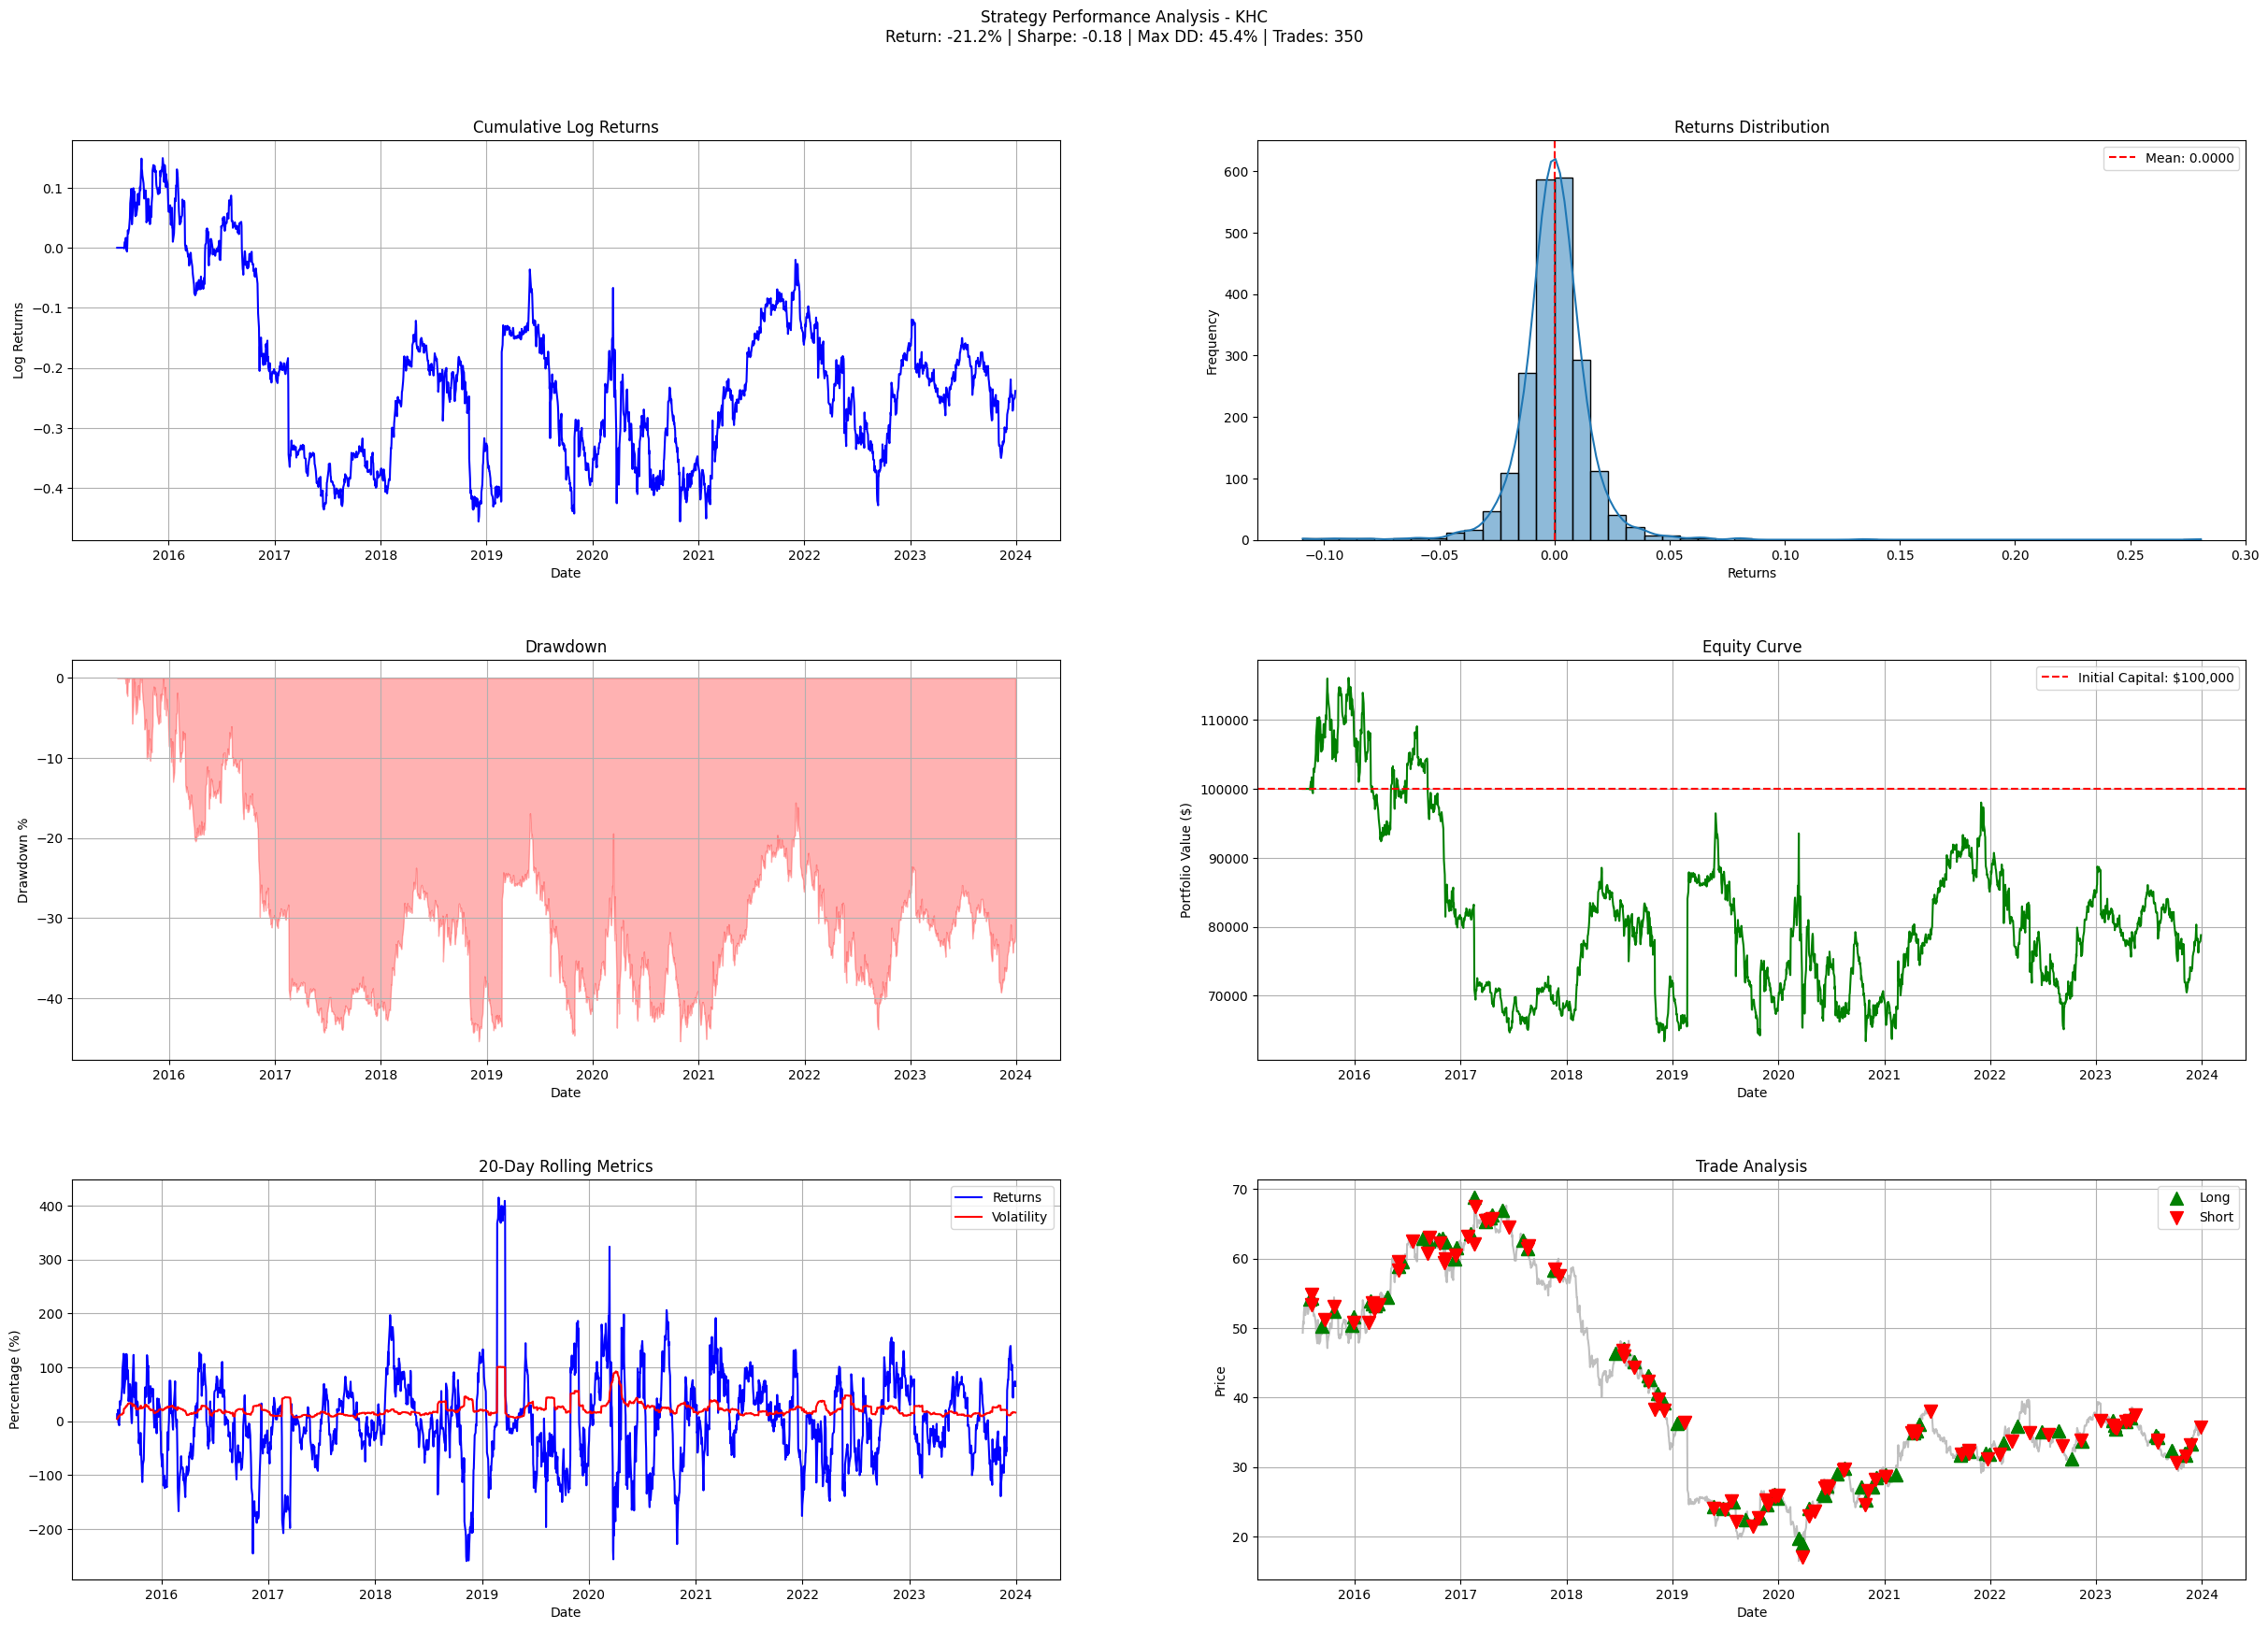

In [12]:
WeightedMCRSIStrategy_1.plot_strategy_performance()

In [9]:
pd.DataFrame(WeightedMCRSIStrategy_1.returns_performance)

,symbol,timestamp,datetime,position,price,total_balance
0,KHC,1436155200000,2015-07-06 04:00:00,0,49.329159,100000.000000
1,KHC,1436241600000,2015-07-07 04:00:00,0,50.458267,100000.000000
2,KHC,1436328000000,2015-07-08 04:00:00,0,50.978886,100000.000000
3,KHC,1436414400000,2015-07-09 04:00:00,0,50.573212,100000.000000
4,KHC,1436500800000,2015-07-10 04:00:00,0,52.270245,100000.000000
...,...,...,...,...,...,...
2133,KHC,1703221200000,2023-12-22 05:00:00,2207,35.130714,77551.307973
2134,KHC,1703566800000,2023-12-26 05:00:00,2207,35.265976,77849.830182
2135,KHC,1703653200000,2023-12-27 05:00:00,2207,35.285305,77892.489442
2136,KHC,1703739600000,2023-12-28 05:00:00,2207,35.497871,78361.623433


## Get the smallest marketcaps and see how well it performs

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


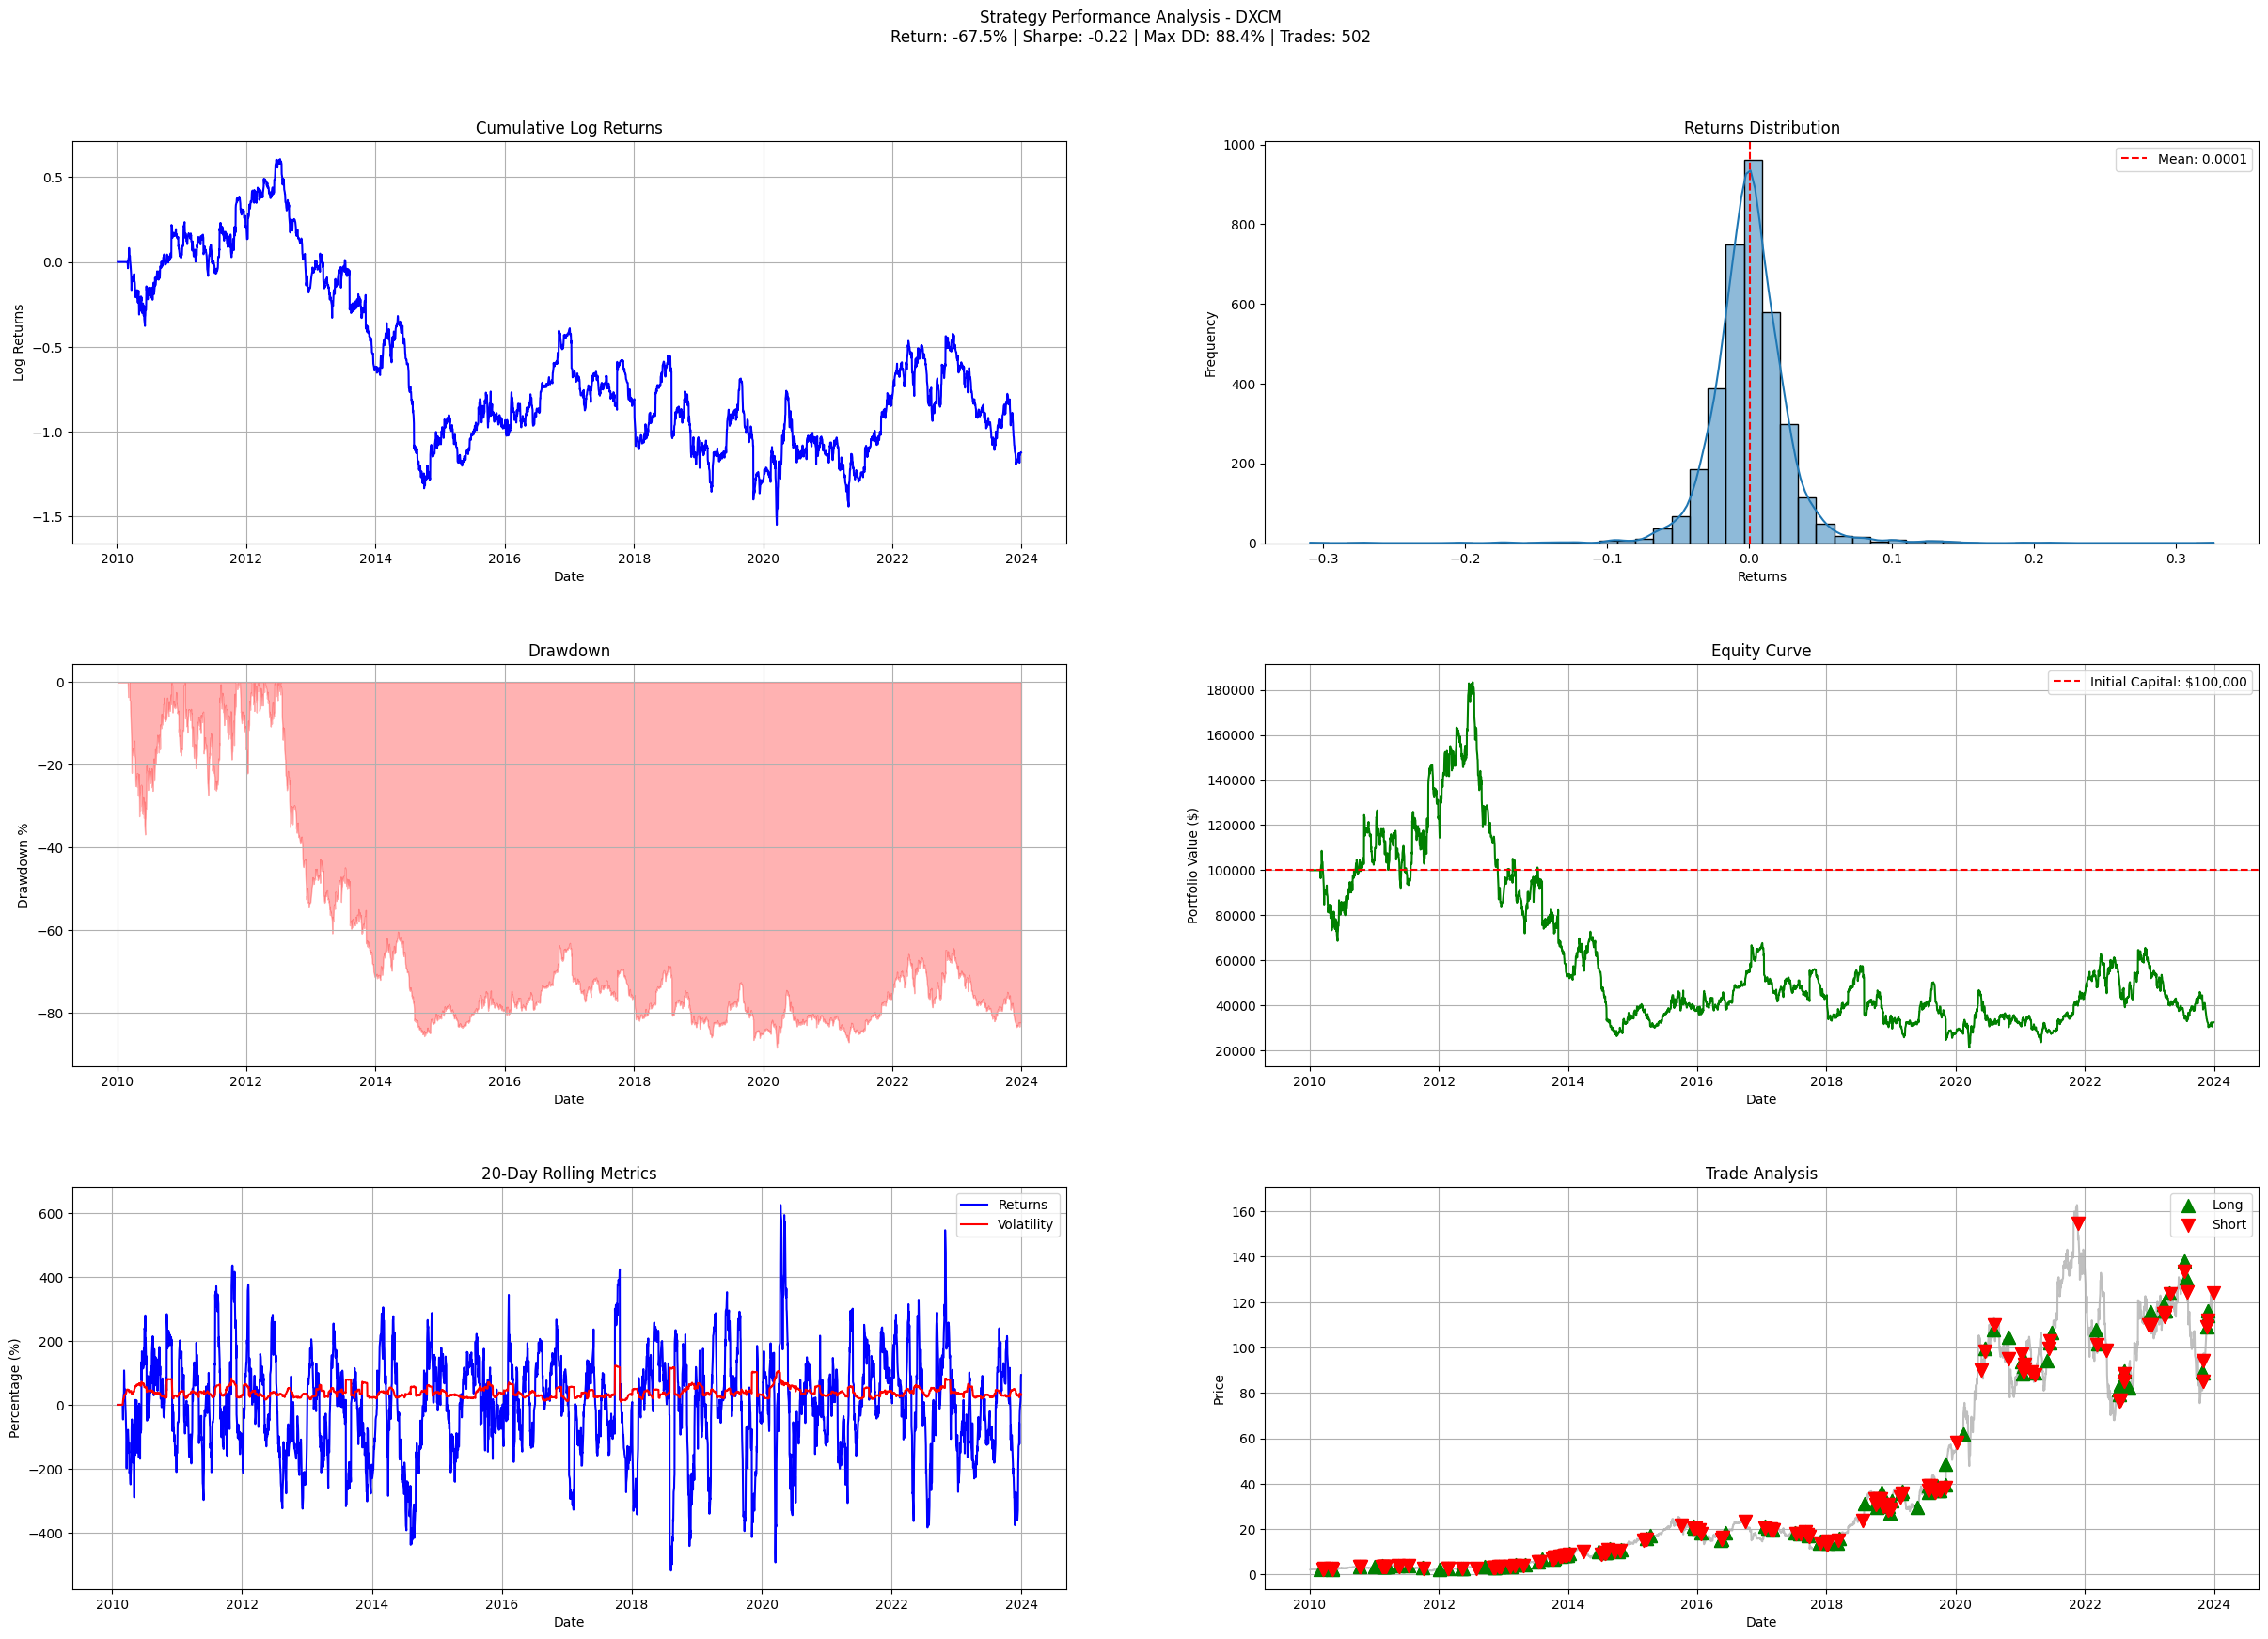

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


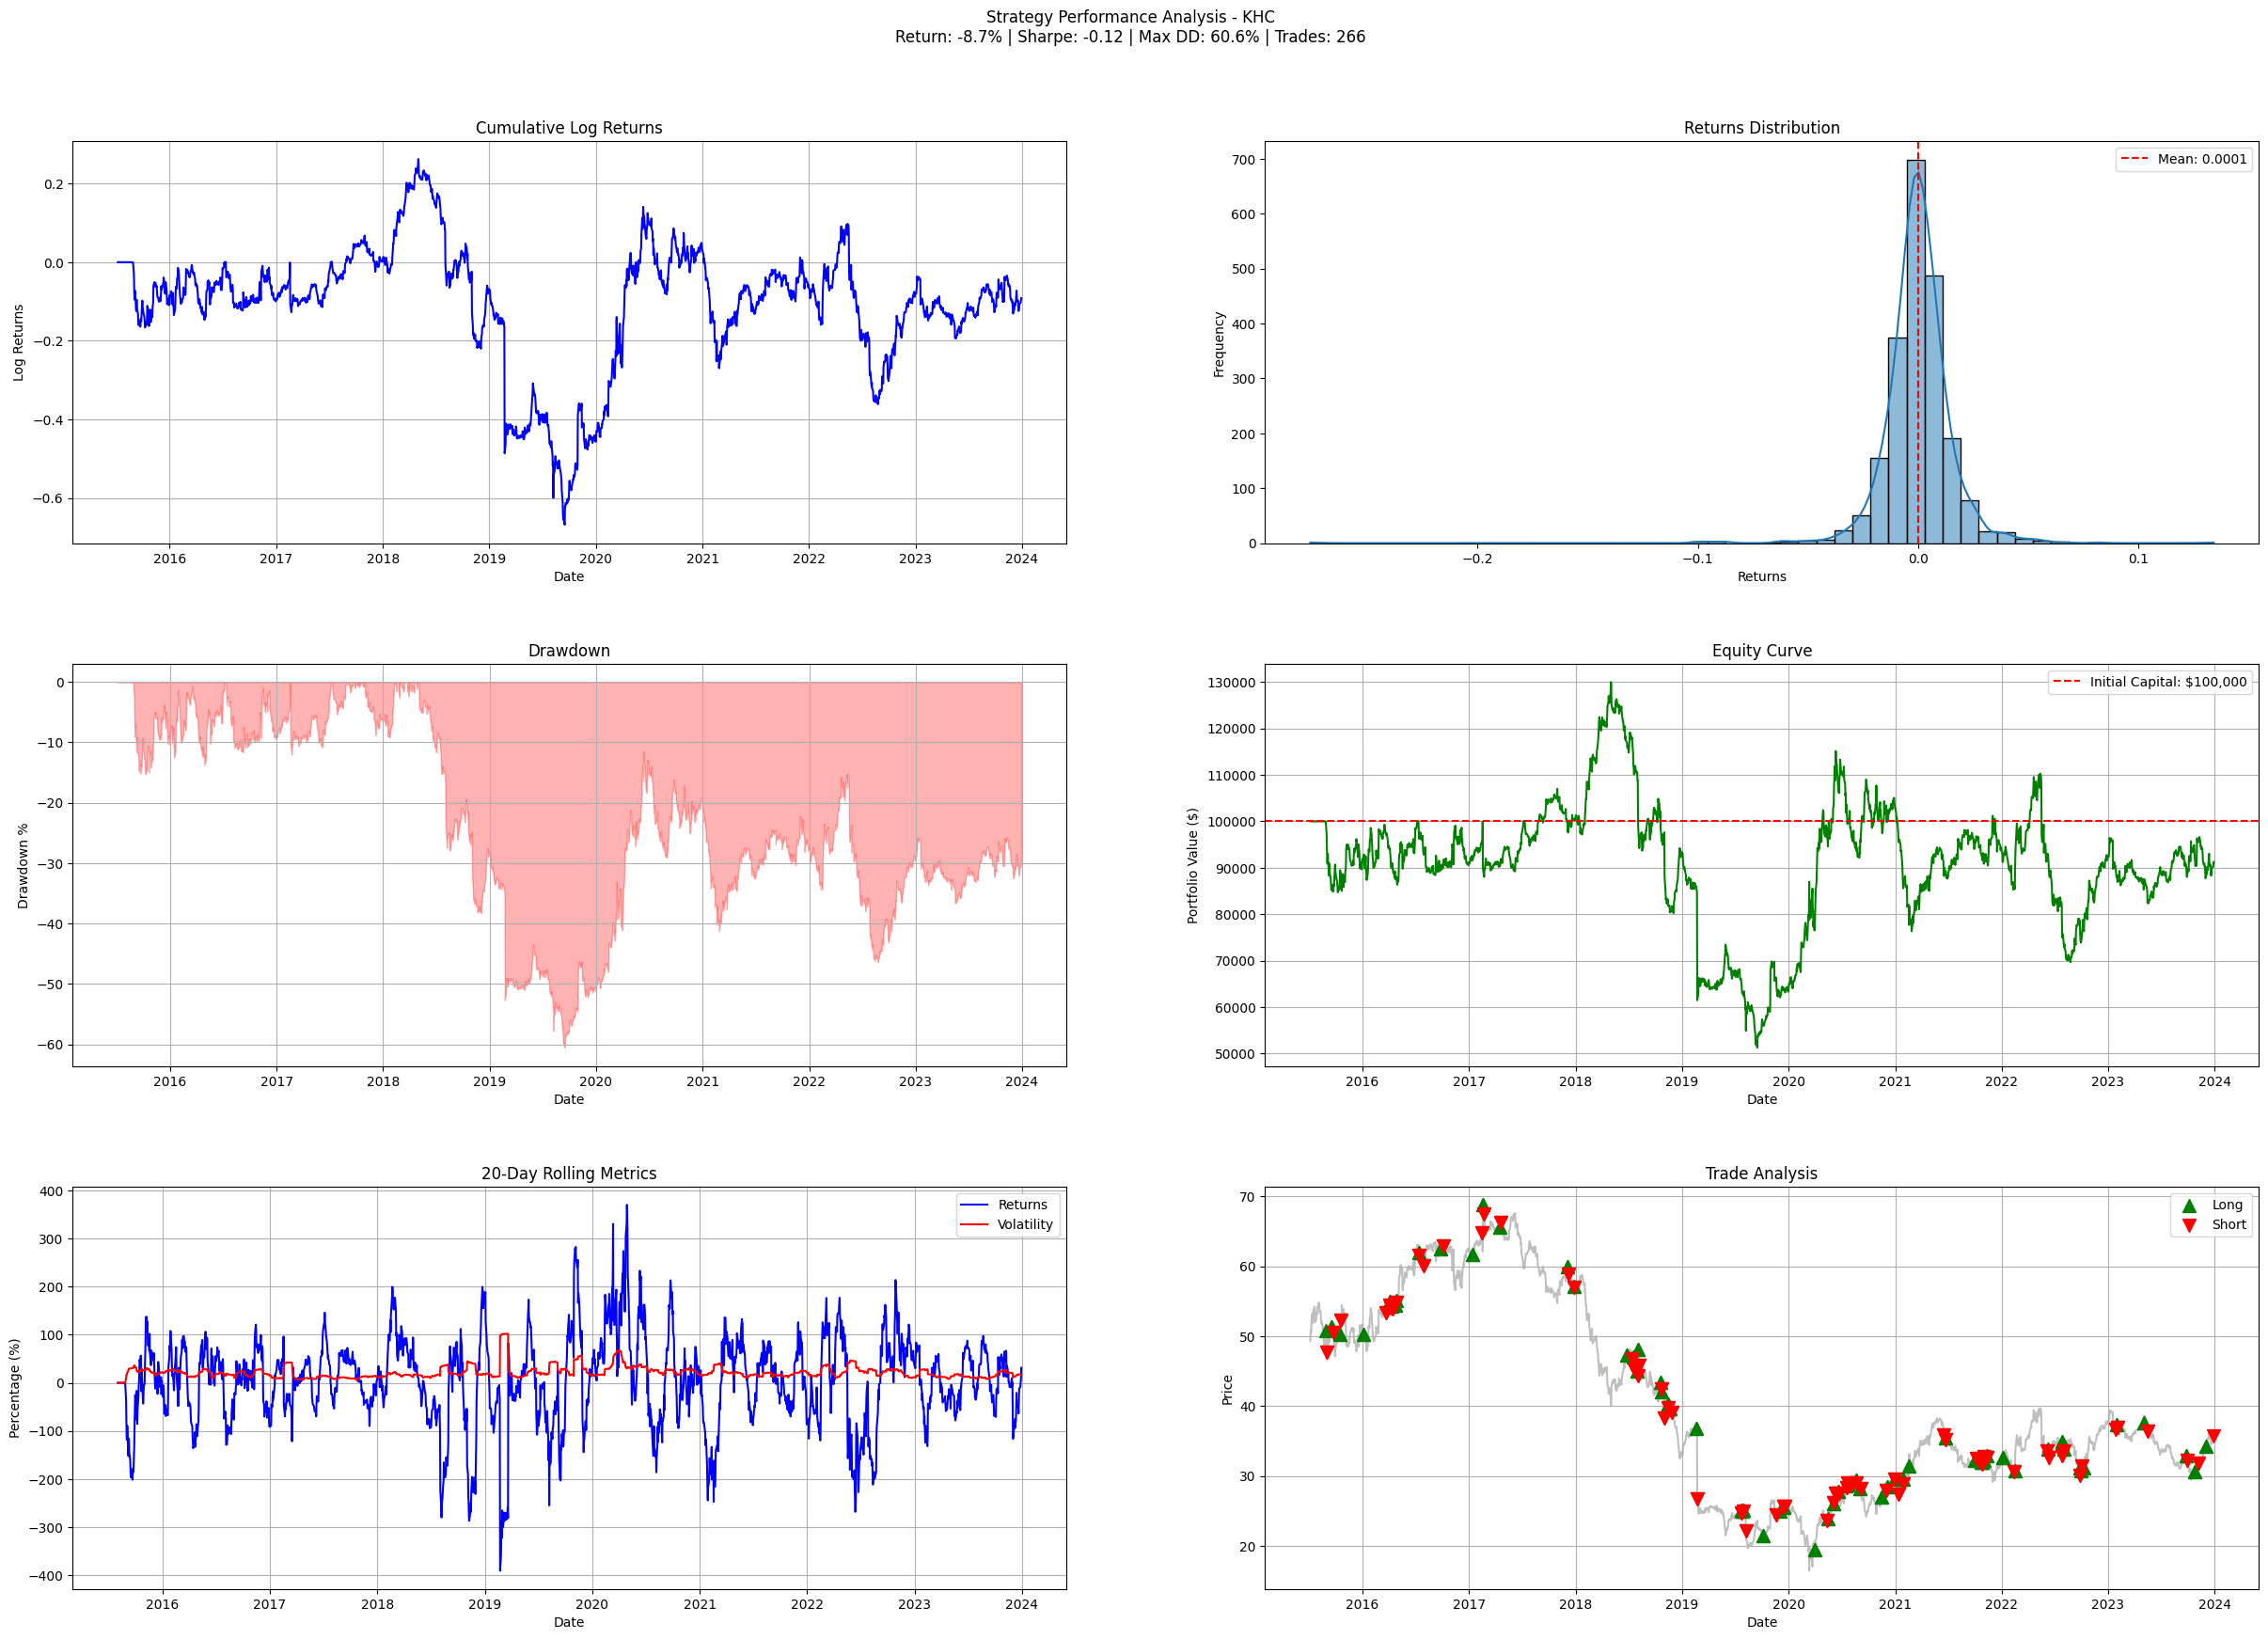

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


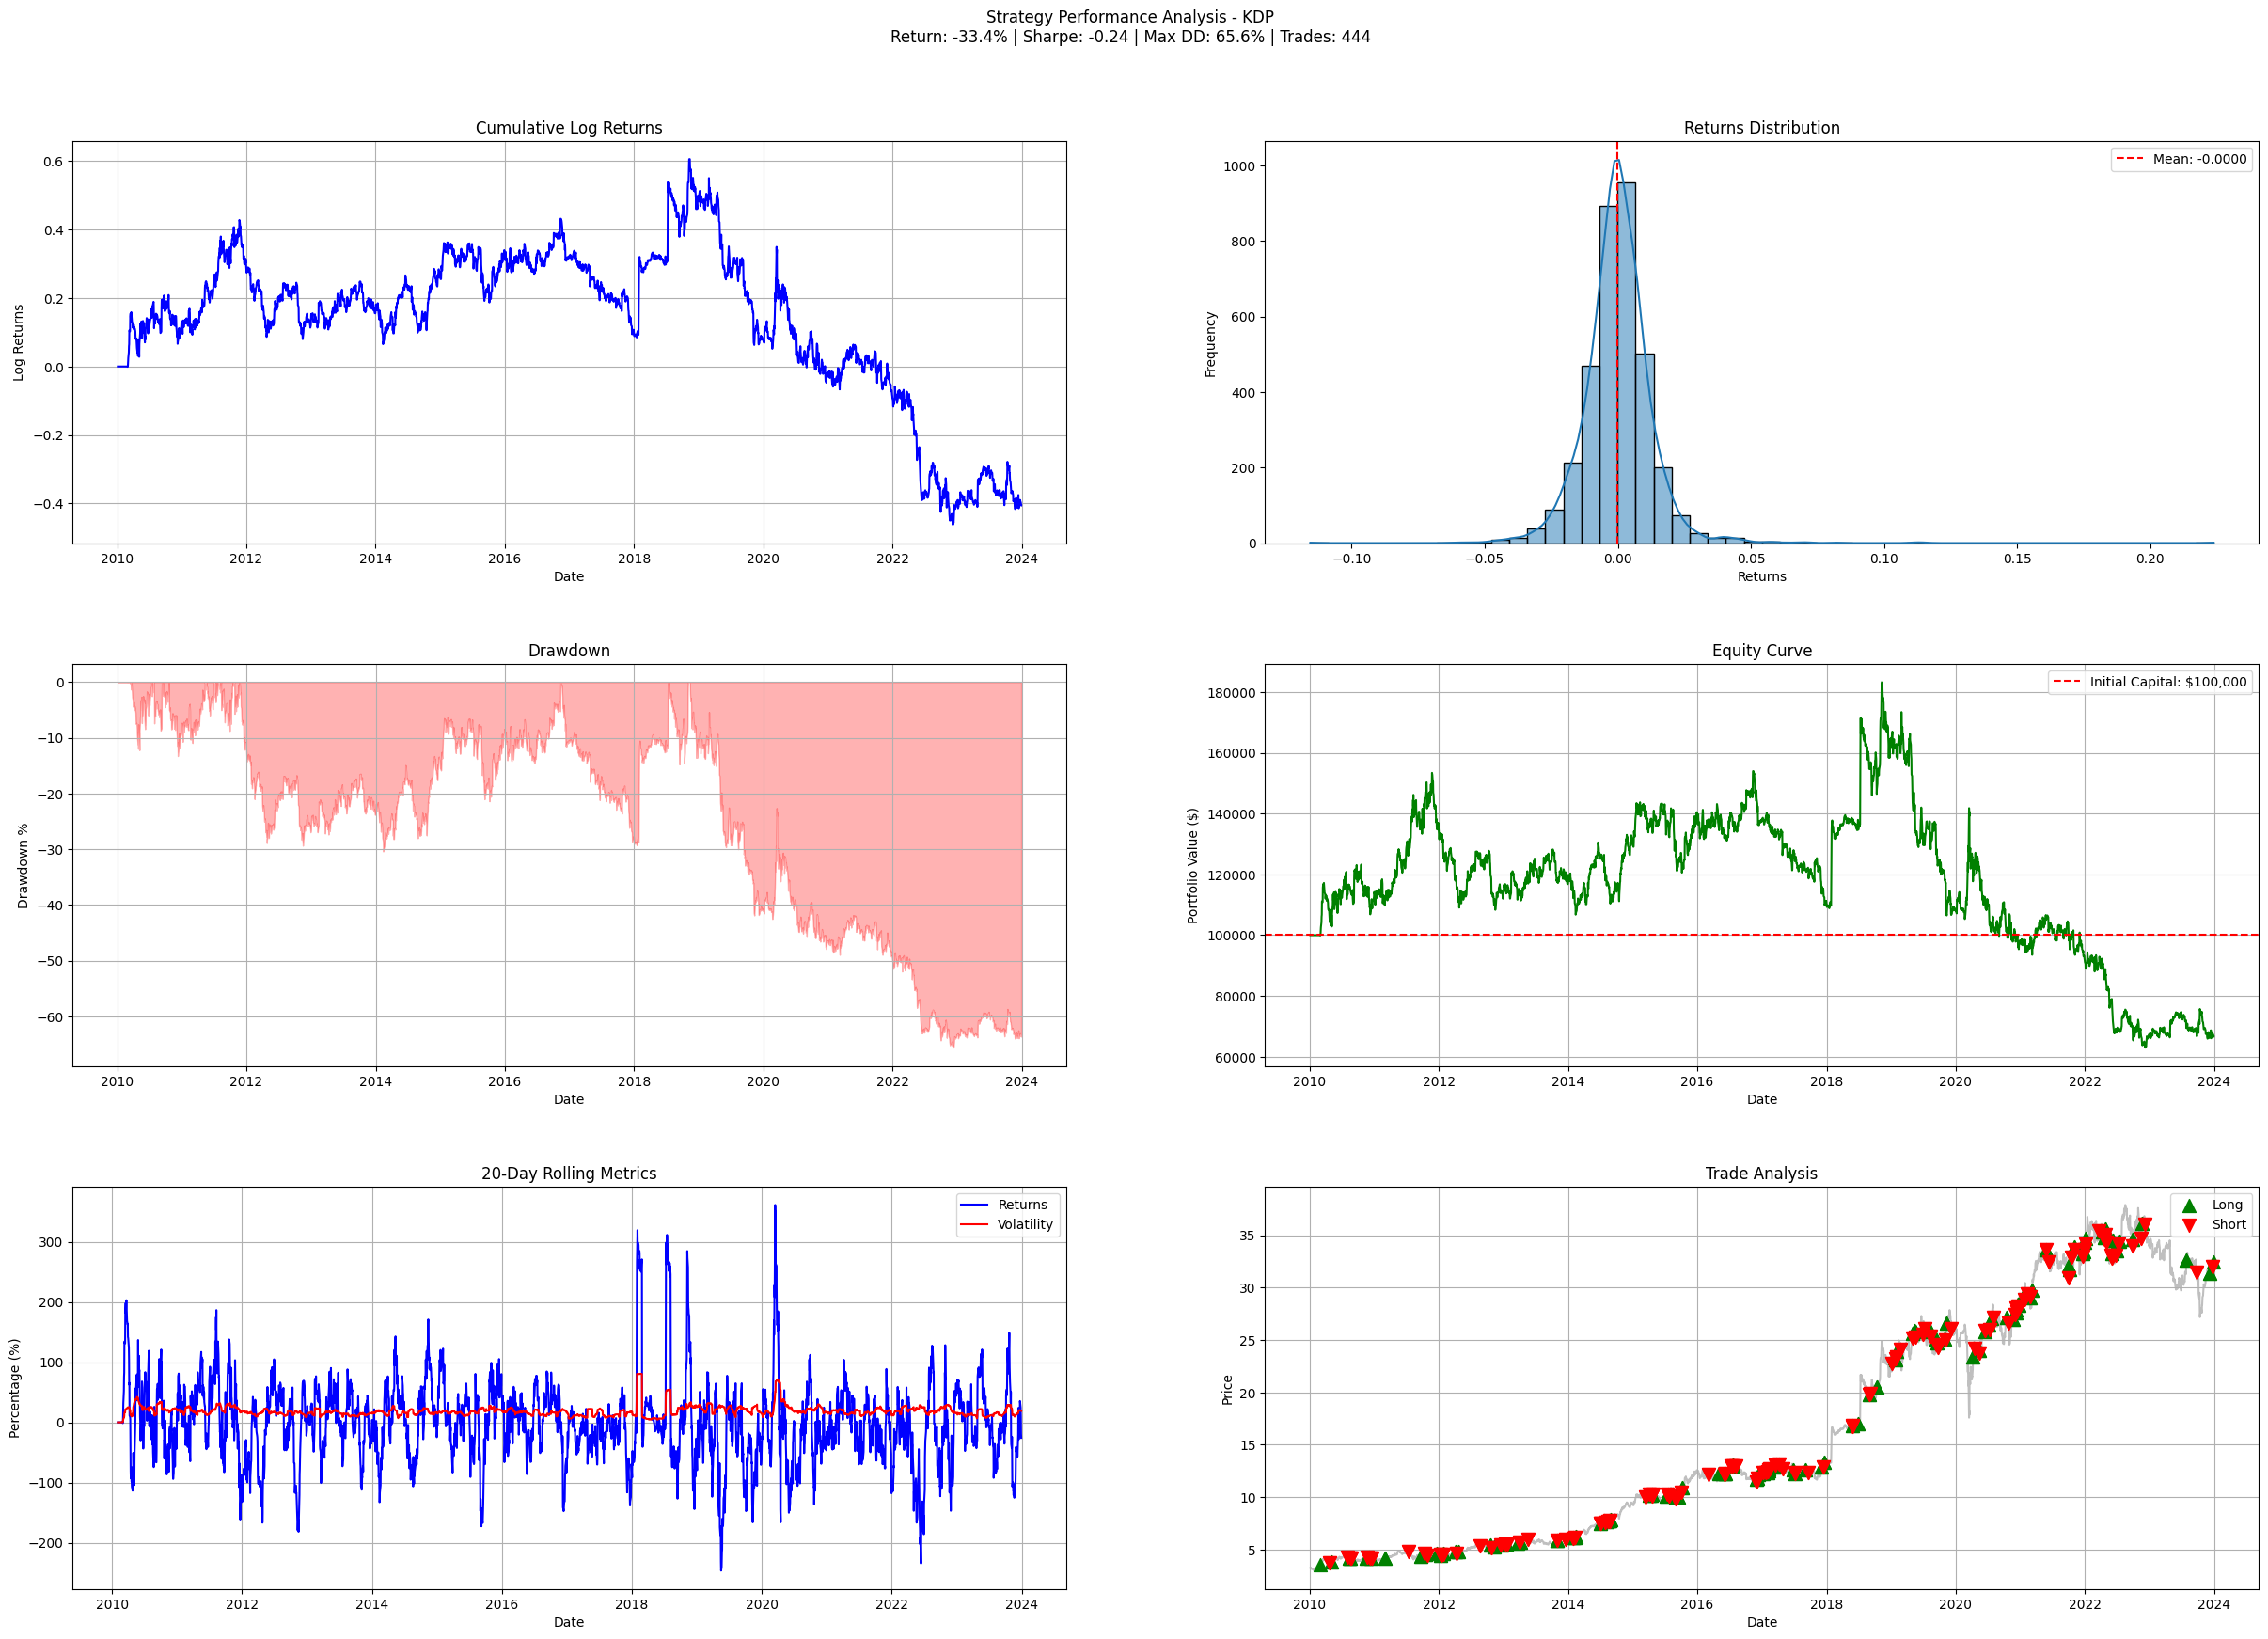

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


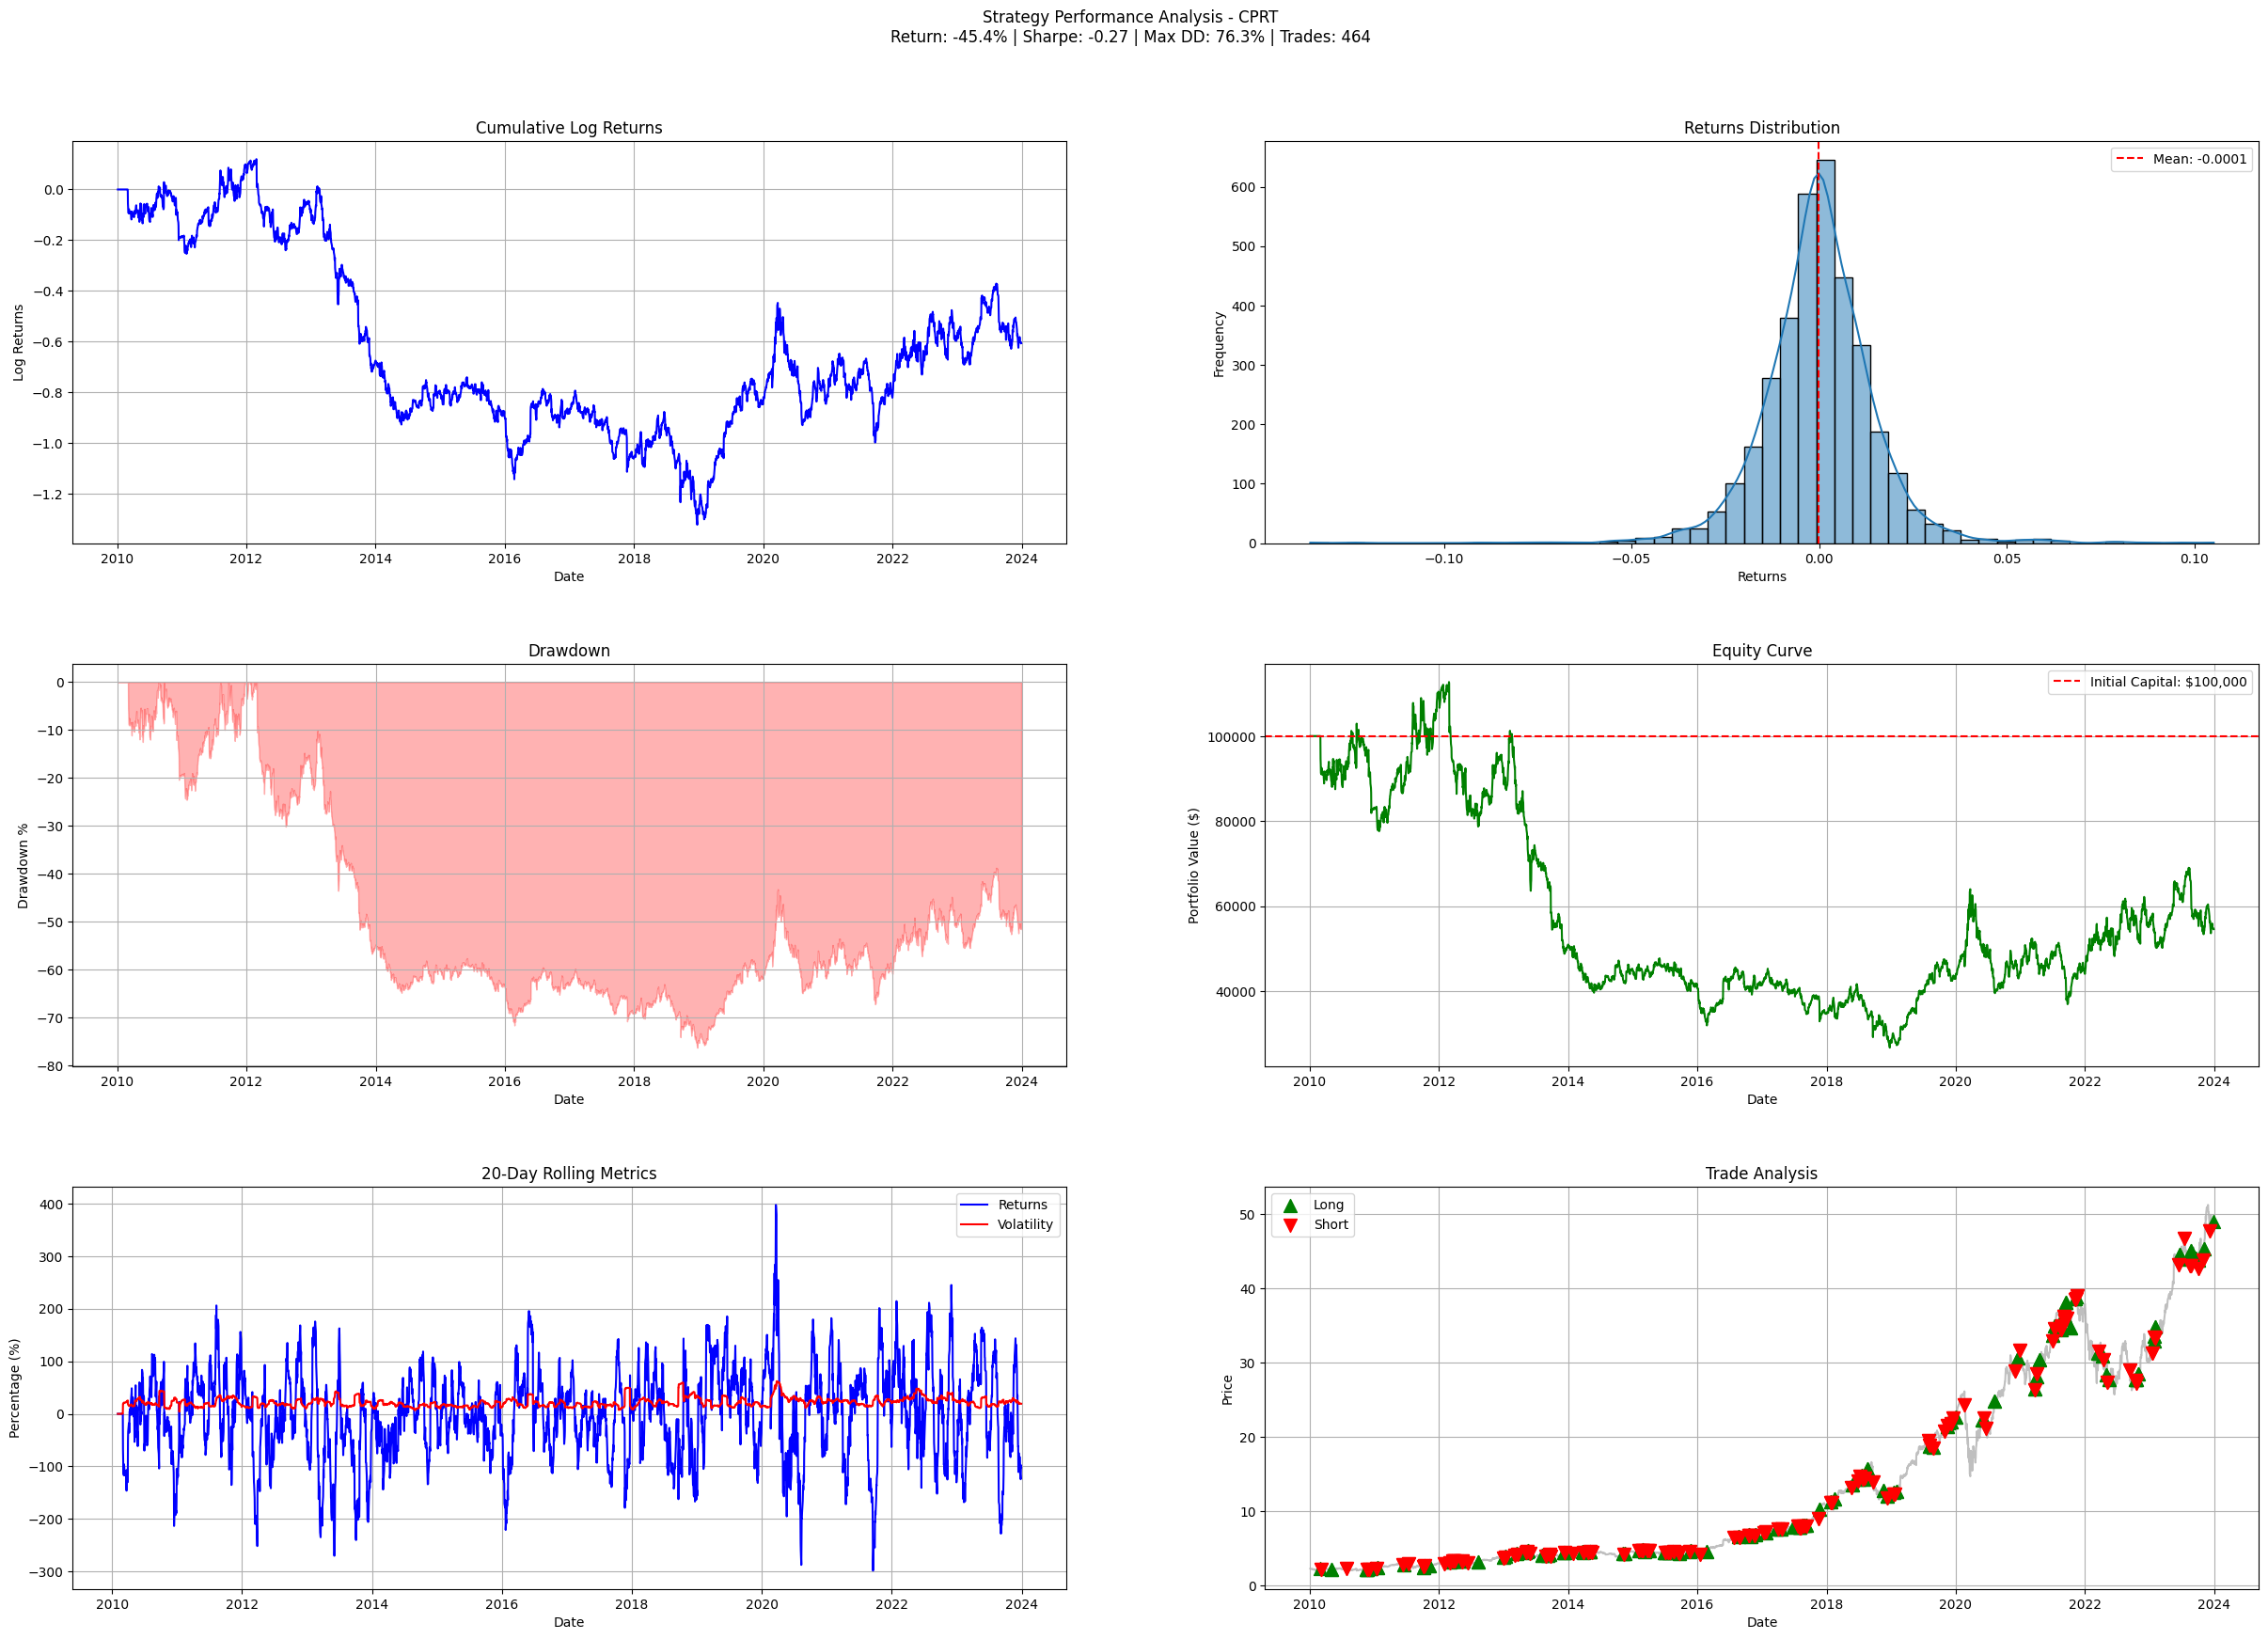

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_3650/575708795.py:551: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


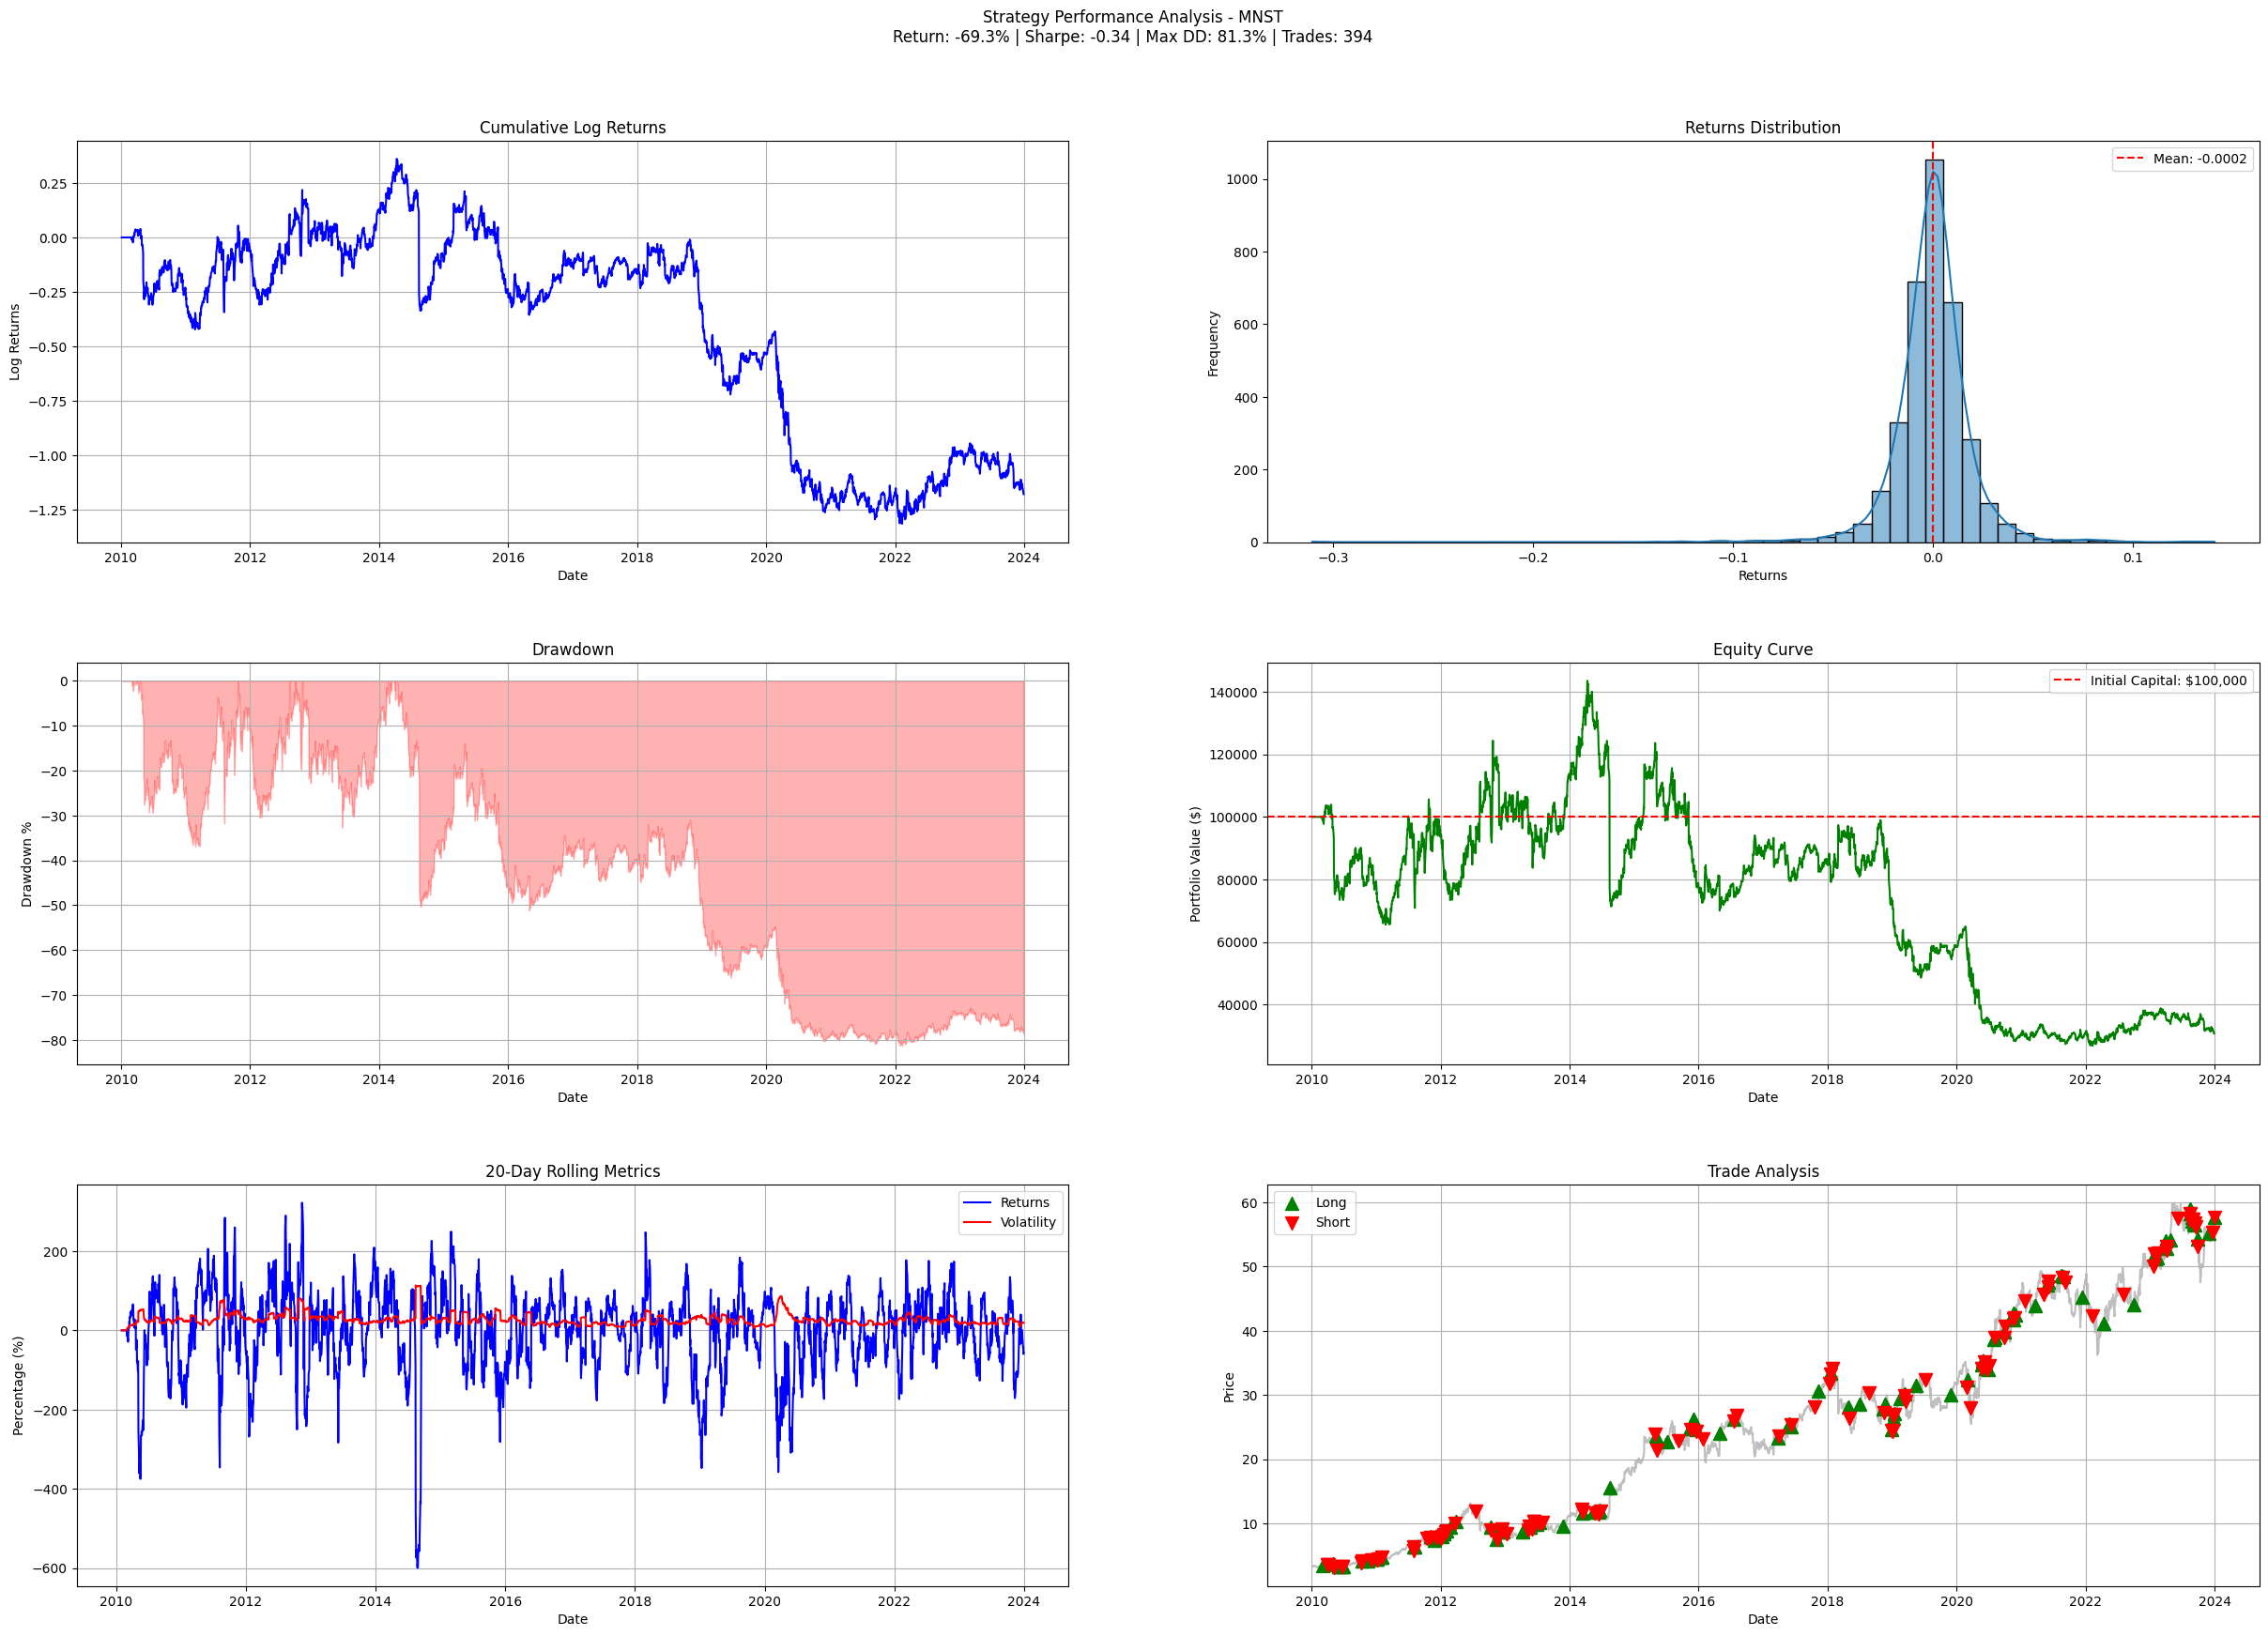

In [13]:
smallest_5_mc = rankings.head(5)['ticker'].tolist()

start_date = '2010-01-01'
end_date = '2024-01-01'
interval = '1d'
rsi_period = 40

for s in smallest_5_mc:
    WeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=start_date,
        end=end_date,
        interval="1d",
        capital=100000,
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=rsi_period,
        qqq_components=qqq_components
    )
    WeightedMCRSIStrategy_test.run_strategy()
    WeightedMCRSIStrategy_test.plot_strategy_performance()

# EventBasedPortfolioManager - A class that takes in a list of EventBasedBacktesters, runs the strategies and calculates the peformance of the portfolio.

1. List of EventBasedBacktester
2. Weights
3. Risk Management
   1. contribution of each strategy
4. Portfolio Analytics 
   1. Calculate portoflio level total expos
   2. portfolio report